<h1>Stock Price prediction using Machine Learning</h1>
<h2 style="color:red;">**This project is not investment advice.**</h2>
<p></p>
<div>
    <p>
        Utilizing Machine Learning, we will predict the closing stock price,
        as the title suggests. <br/>
        Specifically, we use <b>deep neural network</b> for regression.
    </p>
    <p>
        For this project, we will use any stock listed in S&P500.
    </p>
</div>

<h3>Please Make an account at IEX Cloud and grab your token!</h3>
<p>Let's first import our python packages.</p>

In [1]:
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor                     
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import math
import requests           #handles REST API(HTTP/HTTPS) calls
IEX_CLOUD_API_TOKEN = "your token here"

plt.style.use('fivethirtyeight')

<h1>Table of Contents</h1>
<p></p>
<div>
    <ol>
        <li><a href="#1">Choose the target stock with symbol</a></li>
        <li><a href="#2">Get the Stock Chart</a></li>
        <li><a href="#3">Visualize the Price Change</a></li>
        <li><a href="#4">Choose highly correleated feature(s)</a></li>
        <li><a href="#5">Scale the Data for better training</a></li>
        <li><a href="#6">Split data into training and test sets</a></li>
        <li><a href="#7">Train the model</a></li>
        <li><a href="#8">Visualize the Prediction</a></li>
        <li><a href="#9">Evaluate the model</a></li>
    </ol>
</div>

<h2 id="1">1. Choose the target stock with symbol among S&P500</h2>

In [2]:
symbols = pd.read_csv('sp_500_stocks.csv')['Ticker'].values

#verifying the data
symbols

def get_target_stock_symbol():
    """
        This function returns the target stock symbol among S&P500.
    """
    symbol = ""
    while True:
        try:
            symbol = input("Type your target stock: ")
            if symbol in symbols:
                break
            else:
                print("Not available.")
        except:
            print("Not available.")
    return symbol

symbol = get_target_stock_symbol()

Type your target stock: AAPL


<h2 id="2">2. Get the Stock Chart</h2>
<div>
    Let's extract related information from IEX cloud.
</div>

In [3]:
base_url = "https://sandbox.iexapis.com/stable"
Type = "chart"
history = "5y"

api_url = lambda base_url, symbol, Type, token : "{base_url}/stock/{symbol}/{Type}/{history}?token={token}".format(
    base_url = base_url,
    symbol = symbol,
    Type = Type,
    history = history,
    token = token
)
symbol = 'AAPL'
req = requests.get(api_url(
    base_url,
    symbol,
    Type,
    IEX_CLOUD_API_TOKEN
))
assert(req.status_code == 200)


If the code cell above is executed without an error, let's parse the data into the DataFrame.

In [4]:
res = req.json()

columns = list(res[0].keys())
data = {col: [] for col in columns}
for datum in res:
    for col in columns:
        data[col].append(datum[col])
df = pd.DataFrame(data).set_index('date')
df

,close,high,low,open,symbol,volume,id,key,subkey,updated,...,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent
date,,,,,,,,,,,,,,,,,,,,,
2016-07-21,25.6686,25.6686,25.3874,25.4416,AAPL,134429427,RSESITHL_RIIAOCCP,PAAL,,1667429180680,...,99.79,33520581,24.4456,24.1687,24.5766,23.6727,134579306,"Jul 21, 16",0.000000,0.0000
2016-07-22,25.2860,25.6750,24.8261,24.9000,AAPL,116387718,STLHSIC_ARIORPIEC,AALP,,1657560983308,...,103.12,28485934,23.2218,23.8901,23.7267,23.8991,114724920,"Jul 22, 16",-0.196129,-0.0078
2016-07-25,25.0810,25.0810,25.0785,25.0785,AAPL,166088454,ACTOHISECSPI_RLIR,ALAP,,1696760800326,...,99.62,42292841,23.0972,23.1858,23.3620,22.9893,164654238,"Jul 25, 16",-0.338790,-0.0136
2016-07-26,24.2798,25.3741,24.2798,24.4120,AAPL,232723740,HC_SEICIROTPRSLIA,APLA,,1628934245577,...,96.84,56516753,22.7461,23.0057,23.0146,23.5582,229670509,"Jul 26, 16",-0.175296,-0.0072
2016-07-27,26.3260,26.6741,26.3260,26.6741,AAPL,382717596,HTSLISEIPR_RACCIO,LAAP,,1686999216958,...,103.50,96292750,24.7695,24.4424,24.7378,24.5666,384557147,"Jul 27, 16",1.622305,0.0670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14,152.9900,153.9300,152.9900,153.8000,AAPL,128976213,RSOLIA_TCHECIRPSI,APAL,,1687773806964,...,149.19,129904693,152.8000,154.2600,150.2200,148.9200,129293469,"Jul 14, 21",3.596442,0.0247
2021-07-15,153.2400,156.0000,147.3200,152.6900,AAPL,107725540,LSTRSI_ECRHAIOPIC,PALA,,1657901838506,...,147.86,111332664,152.8600,149.6200,156.0000,148.7600,108075893,"Jul 15, 21",-0.683956,-0.0047
2021-07-16,150.4500,154.4000,148.4900,149.3500,AAPL,95030976,IC_LASRIOIPEHTSCR,LAPA,,1633191319935,...,152.17,97520748,150.4400,148.0100,156.9900,148.8400,94190895,"Jul 16, 21",-2.125540,-0.0144


<h2 id="3">3. Visualize the Price Change</h2>
<div>
    <p>
        Before we dive into building a model,let's visualize the data
        and understand the data first.
    </p>
</div>

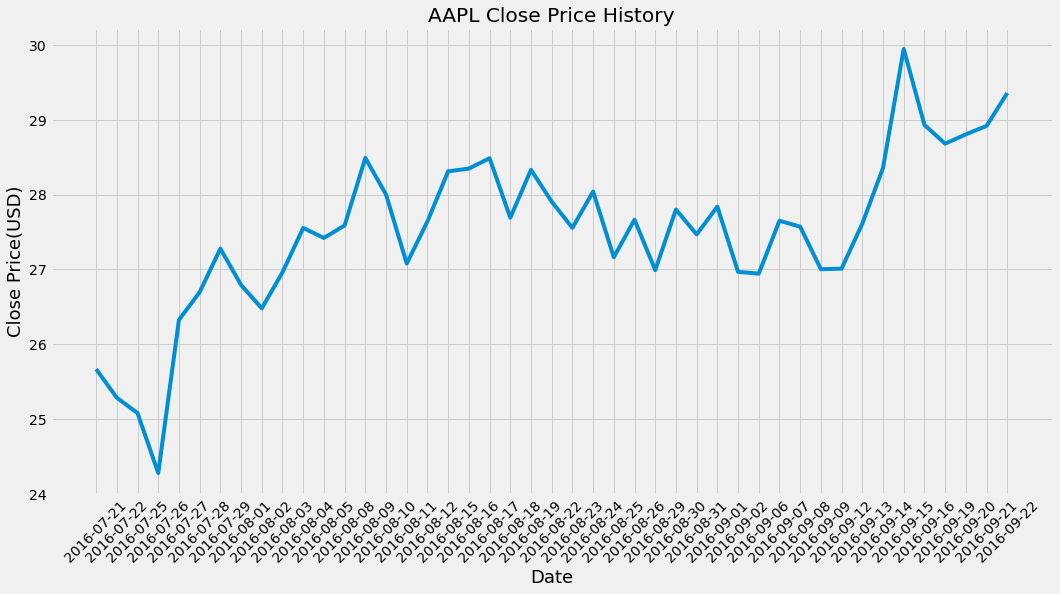

In [5]:
plt.figure(figsize = (16, 8))
plt.title(f"{symbol} Close Price History")
plt.plot(df['close'][:45], label="Close")
plt.xlabel('Date', fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price(USD)', fontsize = 18)
plt.show()

<h2 id="4">4. Choose highly correleated feature(s)</h2>
<p></p>
<div>
    <p>In order to efficiently train the model, it is important to see which features are most correlated.</p>
</div>

In [6]:
corr_matrix = df.corr().round(4)

target = 'close'
slot = lambda col : corr_matrix.loc[target, col] 
features = [col for col in corr_matrix.columns if slot(col) > 0.90 and slot(col) < 1]
print(features)

['high', 'low', 'open', 'changeOverTime', 'marketChangeOverTime', 'fOpen', 'fClose', 'fHigh', 'fLow']


<div>
    We can see that the following features are highly correlated to close price of the stock.
</div>

<h2 id="5">5. Scale the Data for better training</h2>
<div>
    Deep Neural Network requires scaling of data for the better performance.
</div>

In [7]:
X, y = df[features], df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.14185431, -1.12827532, -1.13599795, ..., -1.12222077,
        -1.11554512, -1.13470484],
       [-1.14167336, -1.14483682, -1.15164839, ..., -1.13012813,
        -1.13940353, -1.12817261],
       [-1.15846795, -1.1373896 , -1.14649034, ..., -1.15011789,
        -1.1496414 , -1.1544227 ],
       ...,
       [ 2.49786045,  2.5039426 ,  2.44454342, ...,  2.39269949,
         2.60156676,  2.47669641],
       [ 2.31266763,  2.31923745,  2.36767825, ...,  2.28683293,
         2.25936881,  2.41177808],
       [ 2.38331798,  2.39506688,  2.38039279, ...,  2.37907591,
         2.40122516,  2.46948327]])

<h2 id="6">6. Split data into training and test sets</h2>
<p></p>
<div>
    <p>
        To verify the performance of the model,
        we have to see how model performs on the new data.
    </p>
    <p>We will not shuffle our train-test split since it is a time-series data.</p>
</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle = False)

<h2 id="7">7. Train the model</h2>
<p></p>
<div>
    <p>
        Utilizing the optimal parameters, we can train the model efficiently.
    </p>
</div>

In [18]:
mlp = MLPRegressor(
    hidden_layer_sizes = (100, 100, 100),
    activation = 'relu',
    learning_rate = 'constant',
    shuffle = False, #since it is a time-series data
    max_iter = 10000,
    random_state = 2
)
mlp.fit(X_train, y_train)
y_preds = mlp.predict(X_test).round(4)

<h2 id="8">8. Visualize the Prediction</h2>

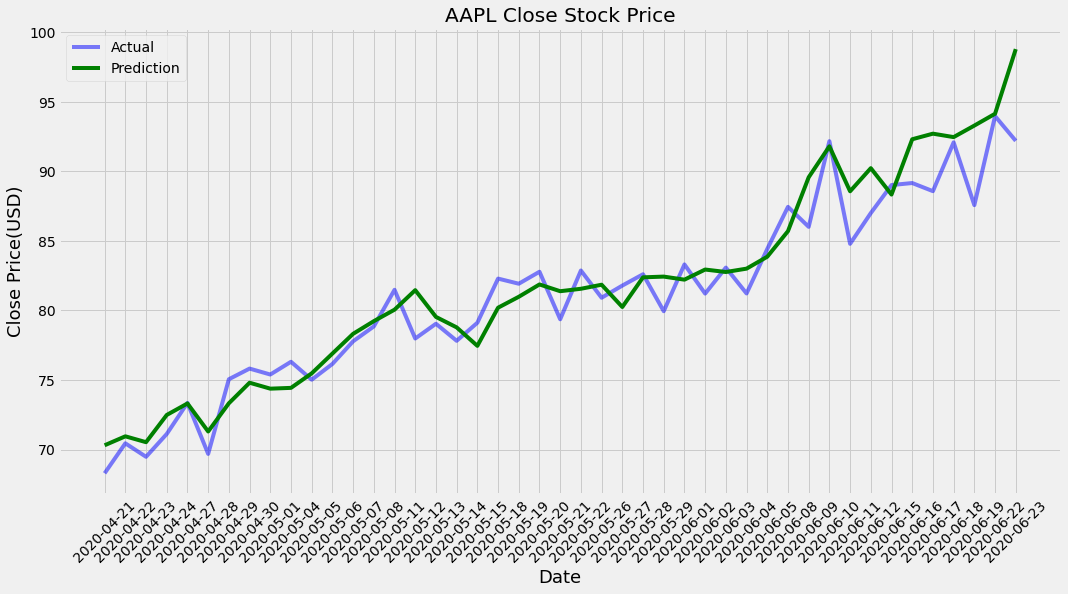

In [19]:
plt.figure(figsize = (16, 8))
plt.title(f"{symbol} Close Stock Price")
plt.plot(y_test[:45], label="Actual", color = "blue", alpha = 0.5)
plt.plot(y_preds[:45], label="Prediction", color = "green")
plt.xlabel('Date', fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price(USD)', fontsize = 18)
plt.legend(loc = "upper left")
plt.show()

<h2 id="9">9. Evaluate the Model</h2>
<p></p>
<div>
    <p>
        To evaluate our model, we will evaluate R^2 score to see variance.
    </p>
</div>

In [20]:
print("R squared value is", r2_score(y_preds, y_test))

R squared value is 0.6759541858613352


Closer to 1, the better the model is.